In [1]:
#un canale

In [4]:
from NewLibraryENG import *
from tqdm.notebook import tqdm
import sklearn.preprocessing as ps
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from random import randint
from fastdtw import fastdtw
import copy
import pymc as pm
name_data = '2018-11-27T10-29-42POP 2 BL .h5'
name_data2 = '2018-11-27T12-03-02POP 2 stimulation.h5'
name_data3='2018-11-27T10-56-39MiP5 KA stimulation.h5'
name_data4='2018-11-27T11-24-28MiP3 stimulation.h5'
name_data5='2018-11-27T10-40-53POP 3 BL .h5'
complete_string='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data
complete_string2='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data2
complete_string3='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data3
complete_string4='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data4
complete_string5='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data5
name_data='2019-01-24T16-00-33Pop1 24hour after.h5'
name_data_st = '2019-01-23T16-06-32Pop1 healthy cortical .h5'
name_data_BL = '2019-01-23T11-19-05PoP1 healthy cortical .h5'
name_data_24 = '2019-01-24T16-00-33Pop1 24hour after.h5'

complete_string='/Users/Gaia_1/Desktop/allh5files/healthy/healthy_baseline/'+name_data_BL
complete_string_st='/Users/Gaia_1/Desktop/allh5files/healthy/healthy_stimulation/'+name_data_st
complete_string_24='/Users/Gaia_1/Desktop/allh5files/healthy/healthy 24hrs later/'+name_data_24

In [5]:
data = h5py.File(complete_string,'r')
data_st = h5py.File(complete_string_st,'r')
data_24 = h5py.File(complete_string_24,'r')
#data = h5py.File(complete_string4,'r') #Stimulated
#data = h5py.File(complete_string5,'r') #BL

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings.shape)

(4222000, 60)


In [6]:
data=data_st
data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings_st = pd.DataFrame(data = data_readings.transpose(), columns = labels)
print(readings_st.shape)

(4260000, 60)


In [7]:
data=data_24
data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings_24 = pd.DataFrame(data = data_readings.transpose(), columns = labels)
print(readings_24.shape)

(4228000, 60)


In [4]:
readings.columns

Index([ b'47',  b'48',  b'46',  b'45',  b'38',  b'37',  b'28',  b'36',  b'27',
        b'17',  b'26',  b'16',  b'35',  b'25', b'Ref',  b'14',  b'24',  b'34',
        b'13',  b'23',  b'12',  b'22',  b'33',  b'21',  b'32',  b'31',  b'44',
        b'43',  b'41',  b'42',  b'52',  b'51',  b'53',  b'54',  b'61',  b'62',
        b'71',  b'63',  b'72',  b'82',  b'73',  b'83',  b'64',  b'74',  b'84',
        b'85',  b'75',  b'65',  b'86',  b'76',  b'87',  b'77',  b'66',  b'78',
        b'67',  b'68',  b'55',  b'56',  b'58',  b'57'],
      dtype='object', name='Label')

In [5]:
inizio=0
len_data=190000 #192 secondi
len_data=len(readings)
prova_multi=readings.iloc[inizio:len_data, :59]
#prova=prova.drop([b'Ref'],axis=1)
prova=prova_multi[b'33']
ref=readings[b'Ref']
ref=ref[inizio:len_data]
#prova=readings.iloc[:150000, :5]
print(prova.shape,ref.shape)

(4222000,) (4222000,)


In [ ]:
merge=

In [6]:
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref)
filt_prova=filtfilt(b,a,prova)
f_prova = filt_prova - filt_ref
prova=f_prova
prova.shape
#r_prova=prova.reshape(-1, 1)
#scaler = StandardScaler()
#s_prova = scaler.fit_transform(r_prova)
#prova=s_prova
#s_prova.shape

(4222000,)

In [7]:
threshold=4*(scipy.stats.median_abs_deviation(prova))
threshold

89.19726789331227

# Spike detection

In [8]:
pos, neg=find_all_spikes(prova,threshold)

  0%|          | 0/4212000 [00:00<?, ?it/s]

positive spikes 14123 negative spikes 33299 detected spikes: 47422 firing rate:  112.32117479867361


BL:            
THRESH=4: fr 131 Hz (15014 pos, 40487 neg)           
THRESH=3: fr 390 Hz (72800 pos, 91948 neg)           
stim:     
THRESH=4: fr 14 Hz (2793 pos, 3261 neg)           
THRESH=3: fr 142.14 Hz (30101 pos, 30450 neg)       
24hrs:    
THRESH=4: fr 556 Hz (85496 pos, 149916 neg)            
THRESH=3: fr 1092.19 Hz (220928 pos, 240849 neg)

# Cutouts

In [9]:
c1=1.5
pos_cut,n_pos, neg_cut,n_neg = cut(pos,neg,prova,c1)
#savedp = copy.deepcopy(pos_cut)
#savedn = copy.deepcopy(neg_cut)

positive spikes removed:  4229 negative spikes removed:  6311


pos_cut=mask_cuts(pos_cut)
neg_cut= mask_cuts(neg_cut)

x=randint(1,min(len(pos_cut),len(neg_cut)))

plt.plot(savedp[x])
plt.plot(pos_cut[x])
plt.show()
#plt.plot(savedn[x])
#plt.plot(neg_cut[x])
#plt.show()

# Clustering

Total spikes:  9894
For 2 clusters, the silhouette score is: 0.157
For 3 clusters, the silhouette score is: 0.041


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.15654144206336437
firing rate threshold:  0.08


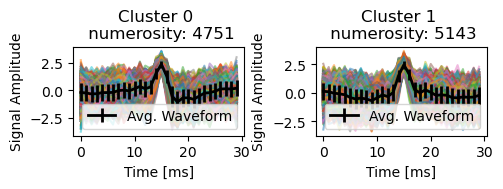

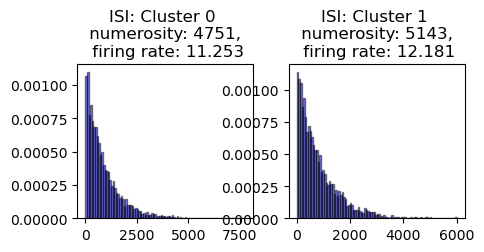

flag:  0
4751 5143
flag:  0
flag:  0
first sub-clustering, count:  1
Total spikes:  4751
For 2 clusters, the silhouette score is: 0.158
For 3 clusters, the silhouette score is: 0.097
For 4 clusters, the silhouette score is: 0.031


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.15764769784955077
firing rate threshold:  0.08


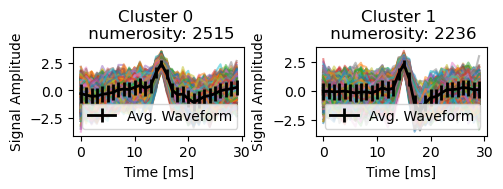

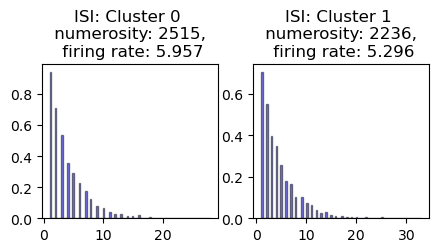

flag:  0
2515 2236
flag:  0
flag:  1
first sub-clustering, count:  2
Total spikes:  2515
For 2 clusters, the silhouette score is: 0.144
For 3 clusters, the silhouette score is: 0.099
For 4 clusters, the silhouette score is: 0.006


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.14380836042334252
firing rate threshold:  0.08


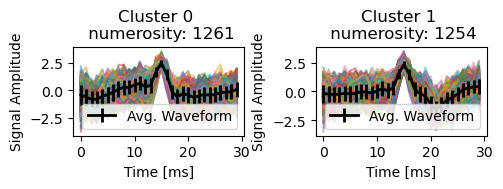

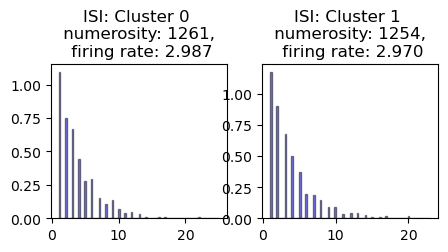

flag:  1
flag:  1
second sub-clustering, count:  0
Total spikes:  2236
For 2 clusters, the silhouette score is: 0.128
For 3 clusters, the silhouette score is: 0.116
For 4 clusters, the silhouette score is: 0.090
For 5 clusters, the silhouette score is: 0.003


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.12750574906788303
firing rate threshold:  0.08


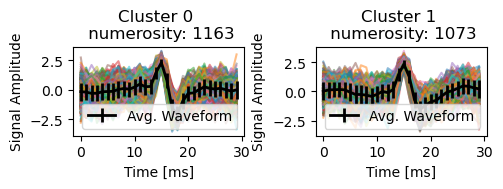

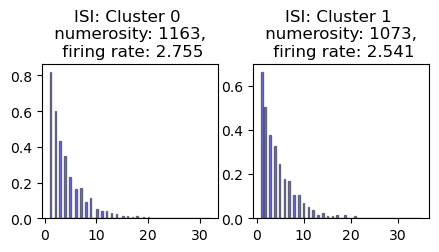

flag:  1
flag:  1
flag:  0
second sub-clustering, count:  0
Total spikes:  5143
For 2 clusters, the silhouette score is: 0.138
For 3 clusters, the silhouette score is: 0.080
For 4 clusters, the silhouette score is: 0.015


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.13799900631923043
firing rate threshold:  0.08


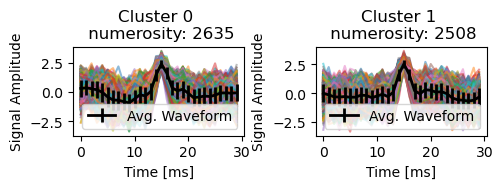

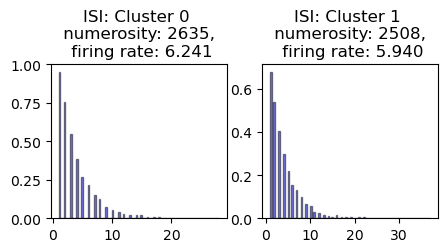

flag:  0
2635 2508
flag:  0
flag:  0
first sub-clustering, count:  1
Total spikes:  2635
For 2 clusters, the silhouette score is: 0.141
For 3 clusters, the silhouette score is: 0.069
For 4 clusters, the silhouette score is: 0.069
For 5 clusters, the silhouette score is: 0.027


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.14122108931499475
firing rate threshold:  0.08


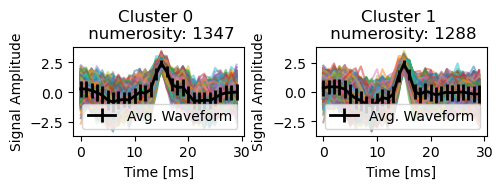

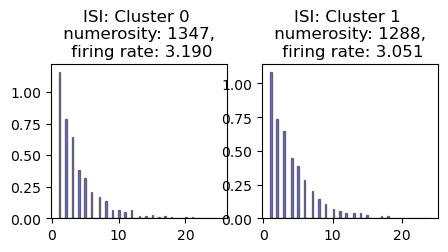

flag:  0
1347 1288
flag:  0
flag:  1
first sub-clustering, count:  2
Total spikes:  1347
For 2 clusters, the silhouette score is: 0.146
For 3 clusters, the silhouette score is: -0.015


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.1462800249187953
firing rate threshold:  0.08


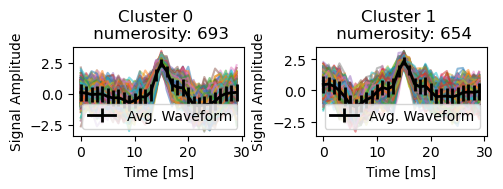

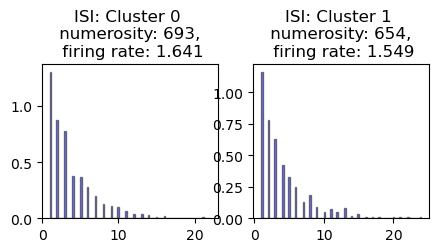

flag:  1
flag:  1
second sub-clustering, count:  0
Total spikes:  1288
For 2 clusters, the silhouette score is: 0.137
For 3 clusters, the silhouette score is: 0.086
For 4 clusters, the silhouette score is: -0.018


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.13730597166436792
firing rate threshold:  0.08


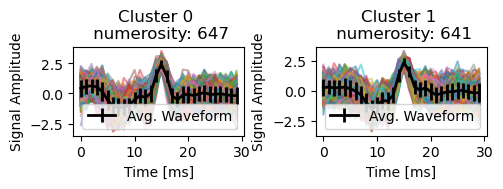

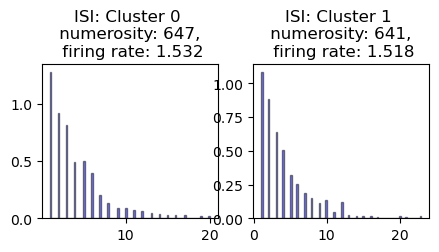

flag:  1
flag:  1
flag:  0
second sub-clustering, count:  0
Total spikes:  2508
For 2 clusters, the silhouette score is: 0.137
For 3 clusters, the silhouette score is: 0.071
For 4 clusters, the silhouette score is: 0.067
For 5 clusters, the silhouette score is: -0.057


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.1374965672305126
firing rate threshold:  0.08


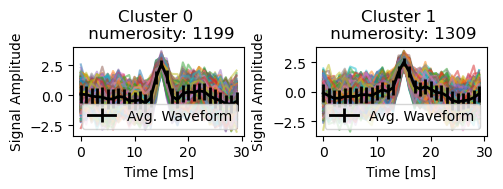

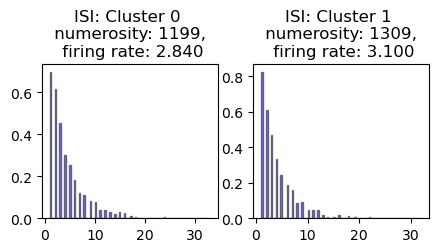

flag:  0
1199 1309
flag:  0
flag:  0
first sub-clustering, count:  1
Total spikes:  1199
For 2 clusters, the silhouette score is: 0.127
For 3 clusters, the silhouette score is: 0.108
For 4 clusters, the silhouette score is: 0.076
For 5 clusters, the silhouette score is: 0.012


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.12748450933150277
firing rate threshold:  0.08


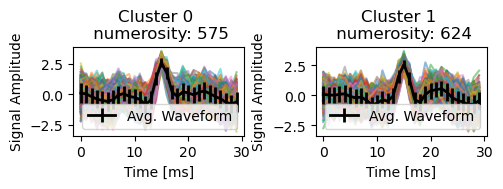

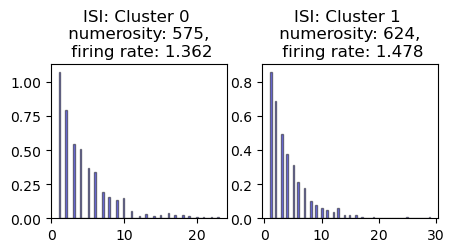

flag:  0
575 624
flag:  0
flag:  1
first sub-clustering, count:  2
Total spikes:  575
For 2 clusters, the silhouette score is: 0.147
For 3 clusters, the silhouette score is: -0.037


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.14729972573182082
firing rate threshold:  0.08


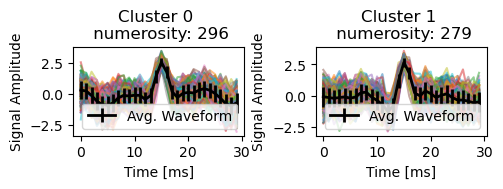

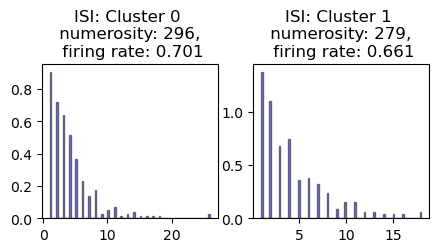

flag:  1
flag:  1
second sub-clustering, count:  0
Total spikes:  624
For 2 clusters, the silhouette score is: 0.123
For 3 clusters, the silhouette score is: 0.086
For 4 clusters, the silhouette score is: 0.053


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.12349057228289087
firing rate threshold:  0.08


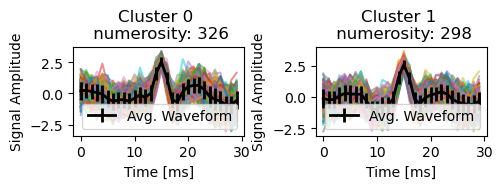

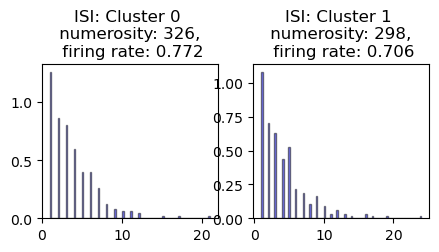

flag:  1
flag:  1
flag:  0
second sub-clustering, count:  0
Total spikes:  1309
For 2 clusters, the silhouette score is: 0.142
For 3 clusters, the silhouette score is: 0.040


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.14190579276947235
firing rate threshold:  0.08


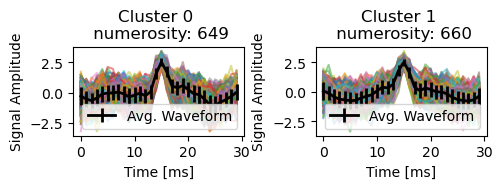

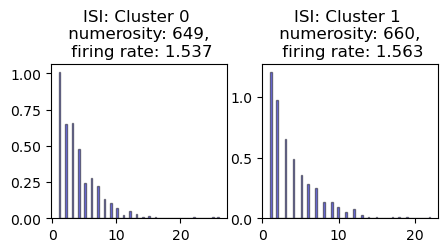

flag:  0
649 660
flag:  0
flag:  1
first sub-clustering, count:  1
Total spikes:  649
For 2 clusters, the silhouette score is: 0.117
For 3 clusters, the silhouette score is: 0.097
For 4 clusters, the silhouette score is: 0.074
For 5 clusters, the silhouette score is: 0.066
For 6 clusters, the silhouette score is: -0.086


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.1165195143471985
firing rate threshold:  0.08


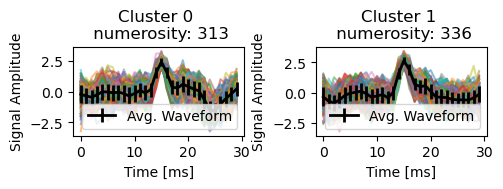

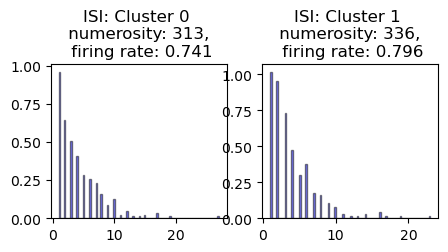

flag:  1
flag:  1
second sub-clustering, count:  0
Total spikes:  660
For 2 clusters, the silhouette score is: 0.128
For 3 clusters, the silhouette score is: 0.101
For 4 clusters, the silhouette score is: 0.096
For 5 clusters, the silhouette score is: 0.017


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.1277410864359907
firing rate threshold:  0.08


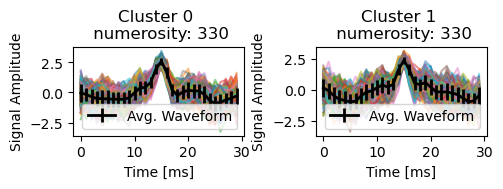

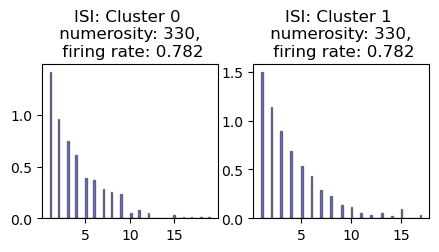

flag:  1
flag:  1
flag:  0
flag:  0
flag:  0


In [10]:
final_data_pos= nested_clus(pos_cut,'fuzzy',n_pos,prova)
#n_min=2
#n_max=16
#final_data_pos= bounded_clus(n_min,n_max,pos_cut,'kmeans',n_pos,prova)

In [11]:
len(final_data_pos)

16

Total spikes:  26988
For 2 clusters, the silhouette score is: 0.138
For 3 clusters, the silhouette score is: 0.039


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.13836185582752436
firing rate threshold:  0.08


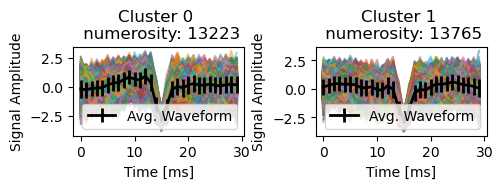

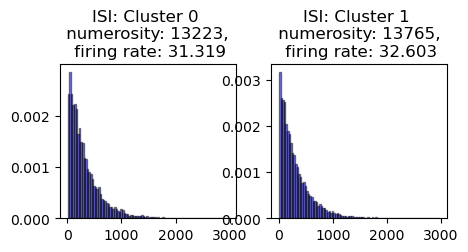

flag:  0
13223 13765
flag:  0
flag:  0
first sub-clustering, count:  1
Total spikes:  13223
For 2 clusters, the silhouette score is: 0.137
For 3 clusters, the silhouette score is: 0.103
For 4 clusters, the silhouette score is: 0.034


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.13654457696333655
firing rate threshold:  0.08


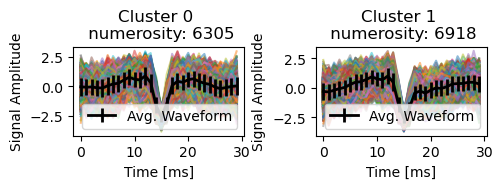

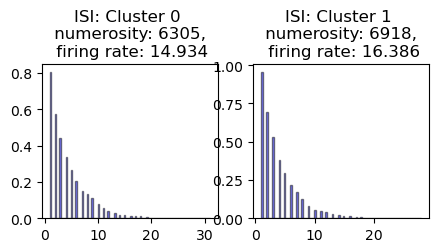

flag:  0
6305 6918
flag:  0
flag:  1
first sub-clustering, count:  2
Total spikes:  6305
For 2 clusters, the silhouette score is: 0.127
For 3 clusters, the silhouette score is: 0.080
For 4 clusters, the silhouette score is: 0.014


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.12729964736611718
firing rate threshold:  0.08


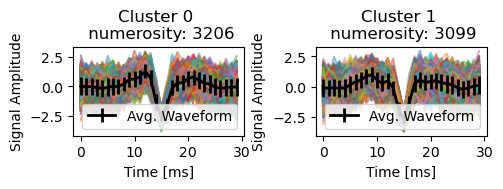

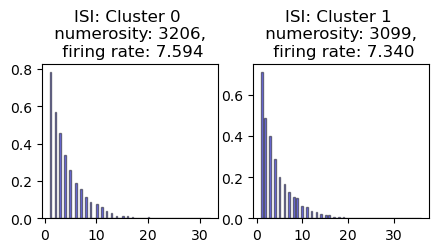

flag:  1
flag:  1
second sub-clustering, count:  0
Total spikes:  6918
For 2 clusters, the silhouette score is: 0.124
For 3 clusters, the silhouette score is: 0.038


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.12406750250223408
firing rate threshold:  0.08


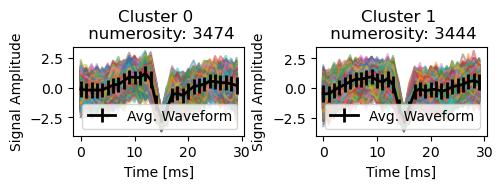

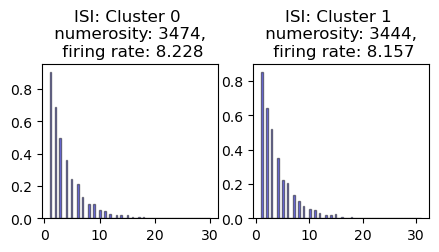

flag:  1
flag:  1
flag:  0
second sub-clustering, count:  0
Total spikes:  13765
For 2 clusters, the silhouette score is: 0.118
For 3 clusters, the silhouette score is: 0.066
For 4 clusters, the silhouette score is: 0.032


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.11764208947479006
firing rate threshold:  0.08


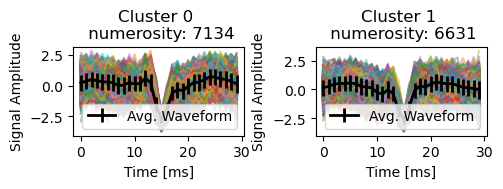

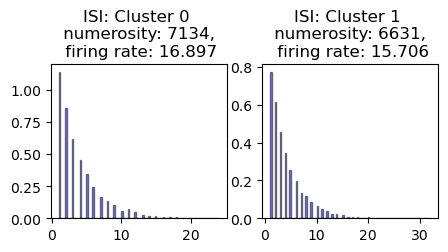

flag:  0
7134 6631
flag:  0
flag:  0
first sub-clustering, count:  1
Total spikes:  7134
For 2 clusters, the silhouette score is: 0.121
For 3 clusters, the silhouette score is: 0.113
For 4 clusters, the silhouette score is: 0.063
For 5 clusters, the silhouette score is: -0.017


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.1209729306903599
firing rate threshold:  0.08


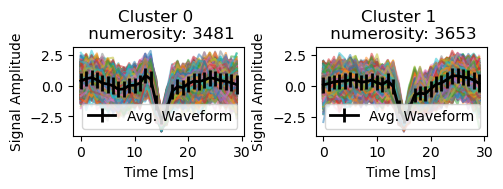

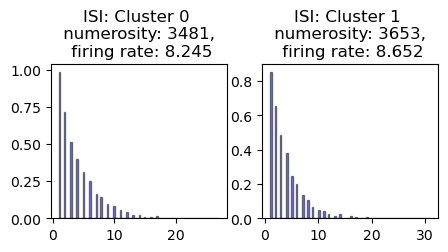

flag:  0
3481 3653
flag:  0
flag:  1
first sub-clustering, count:  2
Total spikes:  3481
For 2 clusters, the silhouette score is: 0.121
For 3 clusters, the silhouette score is: 0.092
For 4 clusters, the silhouette score is: 0.073
For 5 clusters, the silhouette score is: 0.046


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.12105415117879295
firing rate threshold:  0.08


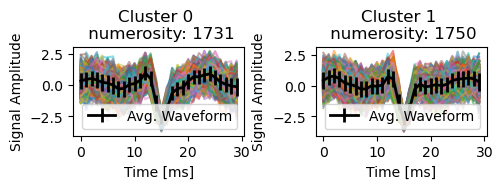

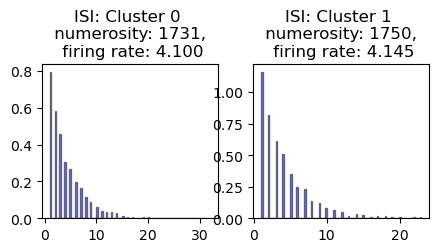

flag:  1
flag:  1
second sub-clustering, count:  0
Total spikes:  3653
For 2 clusters, the silhouette score is: 0.118
For 3 clusters, the silhouette score is: 0.100
For 4 clusters, the silhouette score is: 0.049


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.11847069228446112
firing rate threshold:  0.08


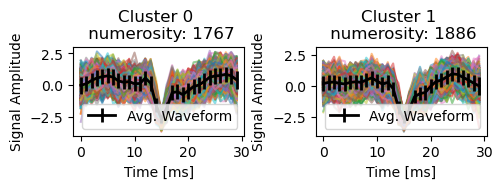

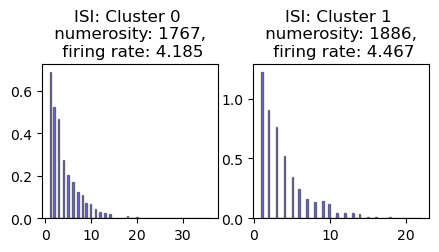

flag:  1
flag:  1
flag:  0
second sub-clustering, count:  0
Total spikes:  6631
For 2 clusters, the silhouette score is: 0.134
For 3 clusters, the silhouette score is: 0.102
For 4 clusters, the silhouette score is: 0.008


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.13437099818316395
firing rate threshold:  0.08


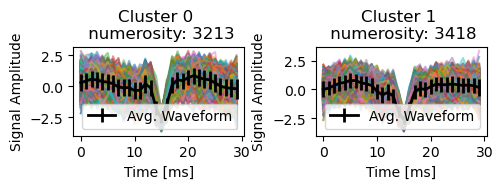

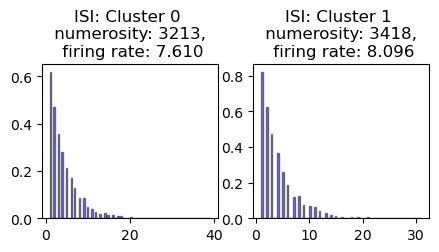

flag:  0
3213 3418
flag:  0
flag:  0
first sub-clustering, count:  1
Total spikes:  3213
For 2 clusters, the silhouette score is: 0.132
For 3 clusters, the silhouette score is: 0.060
For 4 clusters, the silhouette score is: 0.016


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.1318142023481088
firing rate threshold:  0.08


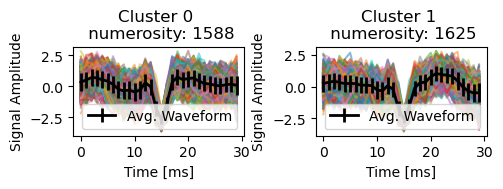

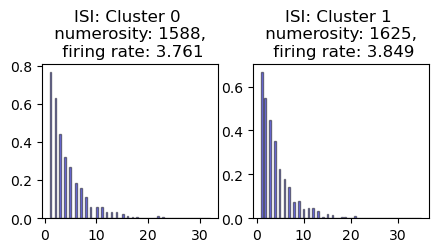

flag:  0
1588 1625
flag:  0
flag:  1
first sub-clustering, count:  2
Total spikes:  1588
For 2 clusters, the silhouette score is: 0.115
For 3 clusters, the silhouette score is: 0.106
For 4 clusters, the silhouette score is: 0.040


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.1149580046795722
firing rate threshold:  0.08


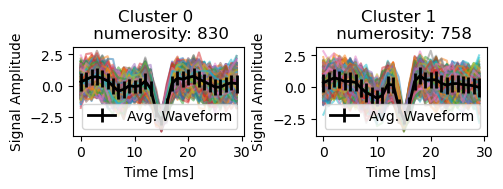

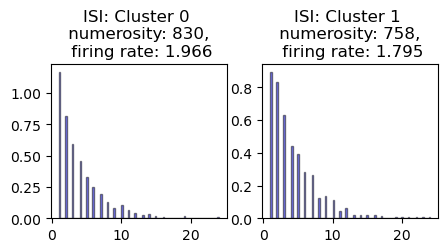

flag:  1
flag:  1
second sub-clustering, count:  0
Total spikes:  1625
For 2 clusters, the silhouette score is: 0.117
For 3 clusters, the silhouette score is: 0.078
For 4 clusters, the silhouette score is: 0.046


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.11672375872821901
firing rate threshold:  0.08


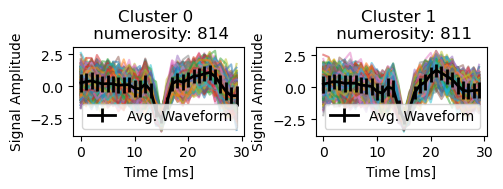

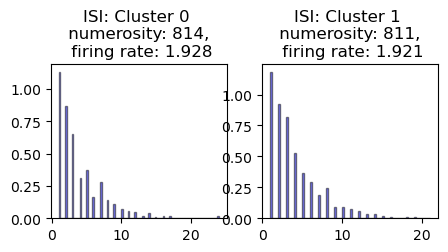

flag:  1
flag:  1
flag:  0
second sub-clustering, count:  0
Total spikes:  3418
For 2 clusters, the silhouette score is: 0.127
For 3 clusters, the silhouette score is: 0.082
For 4 clusters, the silhouette score is: 0.089
For 5 clusters, the silhouette score is: 0.041


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.12700407173237413
firing rate threshold:  0.08


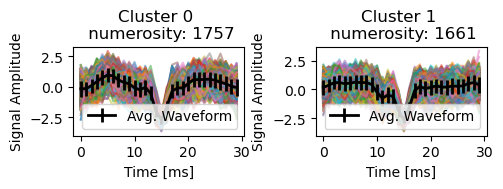

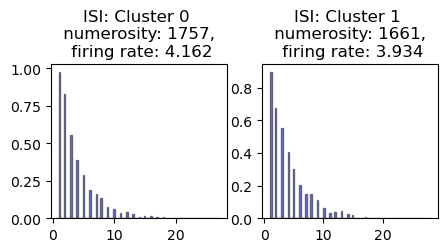

flag:  0
1757 1661
flag:  0
flag:  0
first sub-clustering, count:  1
Total spikes:  1757
For 2 clusters, the silhouette score is: 0.115
For 3 clusters, the silhouette score is: 0.102
For 4 clusters, the silhouette score is: 0.072
For 5 clusters, the silhouette score is: 0.010


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.11517174707764714
firing rate threshold:  0.08


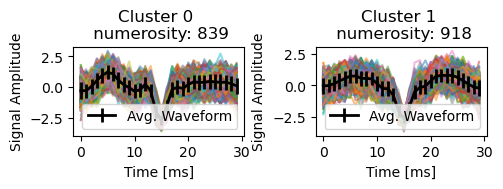

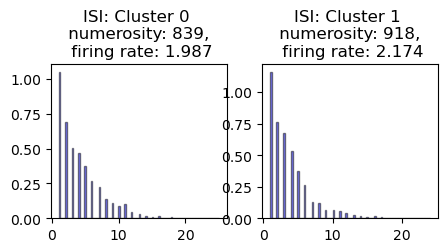

flag:  0
839 918
flag:  0
flag:  1
first sub-clustering, count:  2
Total spikes:  839
For 2 clusters, the silhouette score is: 0.119
For 3 clusters, the silhouette score is: 0.094
For 4 clusters, the silhouette score is: 0.057


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.11910359305252012
firing rate threshold:  0.08


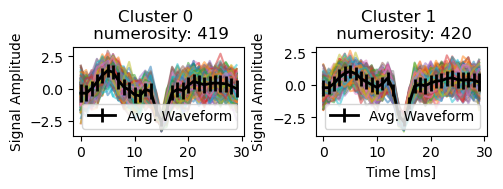

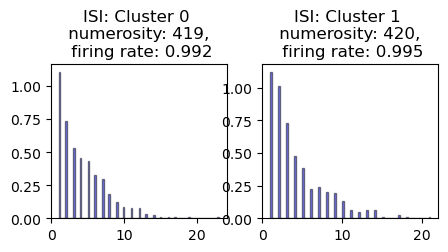

flag:  1
flag:  1
second sub-clustering, count:  0
Total spikes:  918
For 2 clusters, the silhouette score is: 0.113
For 3 clusters, the silhouette score is: 0.095
For 4 clusters, the silhouette score is: 0.068
For 5 clusters, the silhouette score is: 0.058


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.11327374153201919
firing rate threshold:  0.08


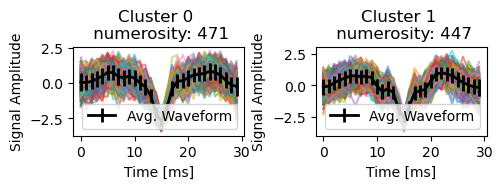

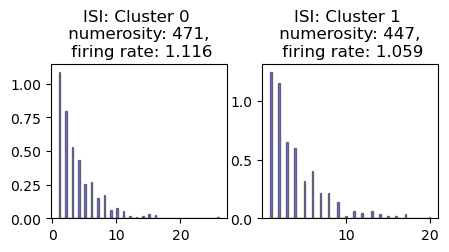

flag:  1
flag:  1
flag:  0
second sub-clustering, count:  0
Total spikes:  1661
For 2 clusters, the silhouette score is: 0.138
For 3 clusters, the silhouette score is: 0.084
For 4 clusters, the silhouette score is: 0.042


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.13774704022569598
firing rate threshold:  0.08


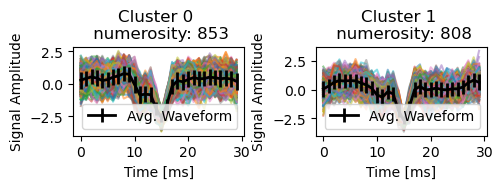

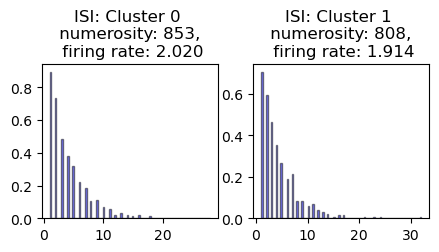

flag:  0
853 808
flag:  0
flag:  1
first sub-clustering, count:  1
Total spikes:  853
For 2 clusters, the silhouette score is: 0.124
For 3 clusters, the silhouette score is: 0.082
For 4 clusters, the silhouette score is: 0.066
For 5 clusters, the silhouette score is: 0.015


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.12413848547063938
firing rate threshold:  0.08


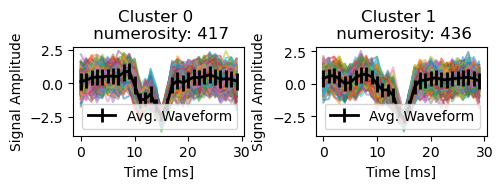

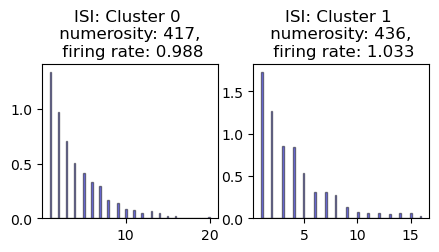

flag:  1
flag:  1
second sub-clustering, count:  0
Total spikes:  808
For 2 clusters, the silhouette score is: 0.122
For 3 clusters, the silhouette score is: 0.098
For 4 clusters, the silhouette score is: 0.060


Best cluster in the range 2  to  10 : 2 , with a silhouette score of:  0.12181548300931139
firing rate threshold:  0.08


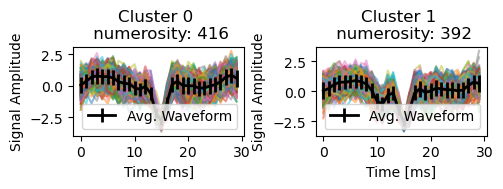

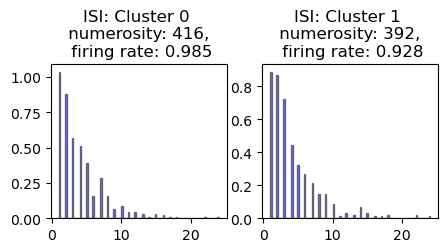

flag:  1
flag:  1
flag:  0
flag:  0
flag:  0
flag:  0


In [12]:
final_data_neg= nested_clus(neg_cut,'fuzzy',n_neg,prova)
#n_min=3
#n_max=18
#final_data_neg= bounded_clus(n_min,n_max,neg_cut,'kmeans',n_neg,prova)

In [16]:
len(final_data_neg)

79

In [17]:
neurons=[]
final_data=final_data_pos
for arr in final_data:
    if len(arr)<30:
        for el in arr:
            neurons.append(el)
    else:
        neurons.append(arr)
final_data=final_data_neg
for arr in final_data:
    if len(arr)<5:
        for el in arr:
            neurons.append(el)
    else:
        neurons.append(arr)
print('len',len(neurons))

len 107


In [18]:
neurons[9]

array([   1,    2,    3,   10,   14,   15,   16,   31,   45,   47,   49,
         58,   59,   60,   71,   80,   88,   89,   91,   93,  107,  113,
        127,  133,  139,  140,  144,  146,  151,  153,  157,  166,  179,
        183,  184,  191,  194,  197,  198,  202,  204,  210,  212,  216,
        234,  235,  242,  247,  250,  256,  261,  270,  271,  272,  273,
        279,  280,  281,  283,  284,  287,  289,  290,  291,  292,  302,
        303,  308,  314,  315,  318,  319,  326,  331,  332,  336,  341,
        342,  350,  357,  358,  360,  363,  365,  369,  372,  373,  374,
        387,  389,  390,  395,  399,  401,  404,  409,  418,  419,  423,
        427,  444,  446,  449,  457,  467,  468,  472,  478,  484,  490,
        493,  494,  500,  504,  506,  516,  517,  520,  523,  528,  532,
        533,  534,  546,  549,  552,  555,  556,  561,  562,  563,  569,
        571,  572,  573,  577,  578,  579,  583,  584,  588,  597,  599,
        602,  603,  605,  607,  609,  610,  611,  6

neurons = []
for neuron in final_data_pos:
    neurons.append(neuron)
for neuron in final_data_neg:
    neurons.append(neuron)
neurons

neur:  3 525


(array([114.,   0., 114.,  71.,   0.,   0.,  52.,   0.,  48.,  32.,   0.,
         23.,   0.,   0.,  13.,  11.,   0.,   0.,  11.,   0.,   8.,   5.,
          0.,   5.,   0.,   5.,   0.,   0.,   1.,   0.,   3.,   1.,   0.,
          2.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          2.,   0.,   0.,   0.,   0.,   1.]),
 array([0.0001 , 0.00015, 0.0002 , 0.00025, 0.0003 , 0.00035, 0.0004 ,
        0.00045, 0.0005 , 0.00055, 0.0006 , 0.00065, 0.0007 , 0.00075,
        0.0008 , 0.00085, 0.0009 , 0.00095, 0.001  , 0.00105, 0.0011 ,
        0.00115, 0.0012 , 0.00125, 0.0013 , 0.00135, 0.0014 , 0.00145,
        0.0015 , 0.00155, 0.0016 , 0.00165, 0.0017 , 0.00175, 0.0018 ,
        0.00185, 0.0019 , 0.00195, 0.002  , 0.00205, 0.0021 , 0.00215,
        0.0022 , 0.00225, 0.0023 , 0.00235, 0.0024 , 0.00245, 0.0025 ,
        0.00255, 0.0026 ]),
 <BarContainer object of 50 artists>)

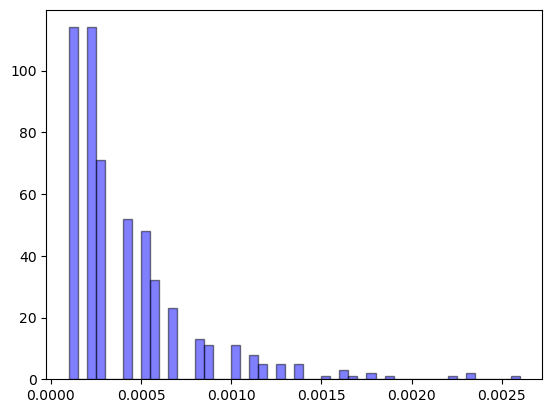

In [27]:
x=randint(0,len(neurons)-1)
print('neur: ',x,len(neurons[x]))
data_healthy=neurons[x]
ISI_healthy = np.diff(data_healthy)/10000
plt.hist(ISI_healthy, bins=50, density=False, alpha=0.5, color='blue', edgecolor='black')

In [ ]:
locs_diff=np.diff(data_healthy)
#plt.axis([-3,500,0,0.05])
plt.hist(locs_diff, bins=50, density=False, alpha=0.5, color='blue', edgecolor='black')

## Point Process

In [ ]:
ISI_data=ISI_healthy

In [ ]:
map_estimate,ppc_trace= Bayesian_mixture_model(ISI_healthy)

In [ ]:
#with model:
#    ppc_trace = pm.sample_posterior_predictive(trace,model=model)

bins = np.arange(0, .5, 1e-3) 
plt.figure (figsize=(14,10))

hist = np.histogram(ppc_trace['posterior_predictive']['like'].values,bins=bins)
#plt.axis([-0.01,0.13,0,160])
a= plt.hist(ISI_healthy,bins)
plt.plot(hist[1][:-1],hist[0]/1000,linewidth=3);

In [ ]:
lista_samples=[]
for i in list(ppc_trace['posterior_predictive']['like'].values):
    lista_samples.extend(i)

In [ ]:
counts, _ = np.histogram(ISI_healthy, bins) 
prob_emp = counts / np.sum(counts)
counts, _ = np.histogram(lista_samples, bins) 
prob_model = counts / np.sum(counts)

Femp = np.cumsum(prob_emp)           
Fmodel = np.cumsum(prob_model)          
plt.figure()
plt.plot(bins[:-1], Femp)                
plt.plot(bins[:-1], Fmodel, 'r')       
#plt.xlim([0, 0.2])                  
plt.xlabel('Time [s]')
plt.ylabel('CDF')
plt.legend(['Empirical','Model'])
plt.show()

In [ ]:
plt.figure()
Nlow = len(ISI_healthy)  
# Plot the confidence bounds
plt.plot([0, 1], [x + 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot([0, 1], [x - 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot(Femp, Fmodel)
#plt.axis([0, 1, 0, 1])         
plt.xlabel('Model CDF')
plt.ylabel('Empirical CDF')
plt.show()

In [ ]:
#plt.plot(Femp)
#plt.plot(Fmodel)
plt.plot(Femp,Fmodel)

In [ ]:
map_estimate = pm.find_MAP(model=model)
del map_estimate['w_simplex__']
del map_estimate['mu1_interval__']
del map_estimate['lam1_interval__']
del map_estimate['mu2_interval__']
del map_estimate['sigma2_interval__']
del map_estimate['mu3_interval__']
del map_estimate['sigma3_interval__']

map_estimate['w1'] = map_estimate['w'][0]
map_estimate['w2'] = map_estimate['w'][1]
map_estimate['w3'] = map_estimate['w'][2]

del map_estimate['w']


map_estimate

In [ ]:
dataframe = pd.DataFrame()
list_neurons = adj_neur
counter=0
print('Original number of neurons: ',len(list_neurons))
for neuron in list_neurons:
    neuron=neuron[neuron>0*10000]
    neuron=neuron[neuron<200*10000]
    print('  Neuron with ',neuron.shape[0],'spikes')
    if neuron.shape[0]>1000:

        counter+=1
    else:
        print('    Excluded neuron with n spikes = ',neuron.shape[0])
        continue

    ISI_healthy = np.diff(neuron)/10000


    map_estimate = Bayesian_mixture_model(ISI_healthy)

    df = pd.DataFrame.from_dict(map_estimate,orient='index')
    dataframe = pd.concat([dataframe,df],axis = 1)
print('Final number of neurons: ',counter)
print('Target = ',target)

In [ ]:
final = dataframe.T
final.to_csv('Data after PP/DataAfter')

## Classification

In [ ]:
def performance_visualizer(trials_obj,n_models,choice=False,**choice_var):
    
    import pandas as pd
    
    performance = [1-t['result']['loss'] for t in trials_obj.trials]
    
    
    hyperparam= list(trials_obj.trials[0]['misc']['vals'].keys())
    
    values_dict ={}
    
    for i in hyperparam:
        
        values_dict[i]=[]
        
        for j in trials_obj.trials:
            
            if(len(j['misc']['vals'][i])==0):
                
                values_dict[i].append(np.NaN)
                
            else:
            
                values_dict[i].append(j['misc']['vals'][i][0])
                
    out = pd.DataFrame.from_dict(values_dict)
    
    out['performance'] = performance
    
    out=out.sort_values(by=['performance'])
    
    
    if choice:
        
        for i in list(choice_var.keys()):
        
            for j,_ in enumerate(choice_var[i]):
        
                out[i]=out[i].replace(j,choice_var[i][j])
    
    return out.tail(n_models)

In [ ]:
dataset = pd.read_csv('Data after PP/Data')
dataset = dataset.drop(['Unnamed: 0'],axis=1)
dataset